_Ref: https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f_

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

ImportError: No module named 'keras'

# Load and transform

In [70]:
df=pd.read_csv('/content/dji_2009-2019.csv')
print('Number of rows and columns:', df.shape)
length = df.shape[0]
print(len)
df.head()

Number of rows and columns: (2767, 7)
<built-in function len>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,8772.250000,9065.280273,8760.780273,9034.690430,9034.690430,213700000
1,2009-01-05,9027.129883,9034.370117,8892.360352,8952.889648,8952.889648,233760000
2,2009-01-06,8954.570313,9088.059570,8940.950195,9015.099609,9015.099609,215410000
3,2009-01-07,8996.940430,8996.940430,8719.919922,8769.700195,8769.700195,266710000
4,2009-01-08,8769.940430,8770.019531,8651.190430,8742.459961,8742.459961,226620000


`close_log`: $log\frac{Price_t}{Price_{t-1}}\;\;\;\;\;$
`target_log`: $log\frac{Price_{t+33}}{Price_{t+28}}$

In [71]:
seq_length = 30
step_predict = 5

In [72]:
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df['vol_log'] = np.log(df['Volume'] / df['Volume'].shift(1))
df['target_log'] = np.log(df['Close'].shift(-step_predict) / df['Close'])

In [73]:
train_df = df[int(length*0.7):int(length*0.9)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.9):int(length*0.95)].copy()
val_df.reset_index(inplace=True)
test_df = df.loc[int(length*0.95):].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape

((554, 11), (138, 11), (139, 11))

`sequence`: $\left[log\frac{Price_t}{Price_{t-1}},log\frac{Price_{t+1}}{Price_{t}}, \dots,log\frac{Price_{t+28}}{Price_{t+27}}\right]$

In [74]:
# sc = MinMaxScaler().fit(train_df[1: train_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# x = sc.transform(train_df[1: train_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# train_df.loc[1: train_df.shape[0]-step_predict-1, 'close_log'] = x

# sc = MinMaxScaler().fit(train_df[1: train_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# x = sc.transform(train_df[1: train_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# train_df.loc[1: train_df.shape[0]-step_predict-1, 'vol_log'] = x

# sc = MinMaxScaler().fit(train_df[1: train_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# x = sc.transform(train_df[1: train_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# train_df.loc[1: train_df.shape[0]-step_predict-1, 'target_log'] = x

In [75]:
# sc = MinMaxScaler().fit(train_df[1: train_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# sequences = sc.transform(train_df[1: train_df.shape[0]-step_predict].close_log.values)
X_train = []
y_train = []
for i in range(seq_length, train_df.shape[0]-step_predict):
    X_train.append(train_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_train.append(train_df.loc[i-1, 'target_log'])
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_train.shape, y_train.shape

((519, 29, 2), (519,))

In [76]:
# sc = MinMaxScaler().fit(val_df[1: val_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# x = sc.transform(val_df[1: val_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# val_df.loc[1: val_df.shape[0]-step_predict-1, 'close_log'] = x

# sc = MinMaxScaler().fit(val_df[1: val_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# x = sc.transform(val_df[1: val_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# val_df.loc[1: val_df.shape[0]-step_predict-1, 'vol_log'] = x

# sc = MinMaxScaler().fit(val_df[1: val_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# x = sc.transform(val_df[1: val_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# val_df.loc[1: val_df.shape[0]-step_predict-1, 'target_log'] = x

In [77]:
X_val = []
y_val = []
for i in range(seq_length, val_df.shape[0]-step_predict):
    X_val.append(val_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_val.append(val_df.loc[i-1, 'target_log'])
X_val, y_val= np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 2))
X_val.shape, y_val.shape

((103, 29, 2), (103,))

# Model

In [78]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [79]:
inputs = Input(shape=(X_train.shape[1], 2))
lstm1 = LSTM(units=50, return_sequences=True)(inputs)
dropout1 = Dropout(rate=0.5)(lstm1)
lstm2 = LSTM(units=50, return_sequences=True)(dropout1)
dropout2 = Dropout(rate=0.5)(lstm2)
lstm3 = LSTM(units=50)(dropout2)
dropout3 = Dropout(rate=0.5)(lstm3)
fc1 = Dense(units=100)(dropout3)
fc2 = Dense(units=50)(fc1)
fc3 = Dense(units=25)(fc2)
output = Dense(units=1)(fc3)

lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_val, y_val))

Epoch 1/100
17/17 [==============================] - 5s 65ms/step - loss: 4.4549e-04 - val_loss: 2.8569e-04
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 3.3205e-04 - val_loss: 2.7937e-04
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 2.6083e-04 - val_loss: 2.9243e-04
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 2.5641e-04 - val_loss: 2.8883e-04
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 2.4141e-04 - val_loss: 2.8060e-04
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 2.4678e-04 - val_loss: 3.4911e-04
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 2.8661e-04 - val_loss: 3.1801e-04
Epoch 8/100
17/17 [==============================] - 0s 11ms/step - loss: 3.1038e-04 - val_loss: 3.0725e-04
Epoch 9/100
17/17 [==============================] - 0s 11ms/step - loss: 2.7642e-04 - val_loss: 2.7925e-04
Epoch 10/100
17/17 [========

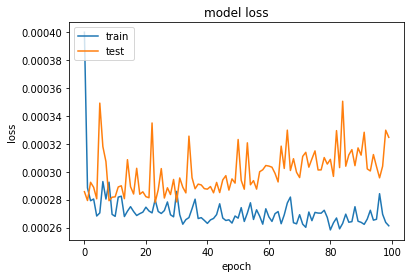

In [80]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict and plot

### Train set

In [81]:
train_price = train_df[seq_length+step_predict:train_df.shape[0]].Close
train_predicted = lstm_model.predict(X_train)
# train_predicted = sc.inverse_transform(train_predicted)
inv = train_df[seq_length:train_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
train_predicted = inv * np.exp(1)**train_predicted
len(train_price), len(train_predicted)

(519, 519)

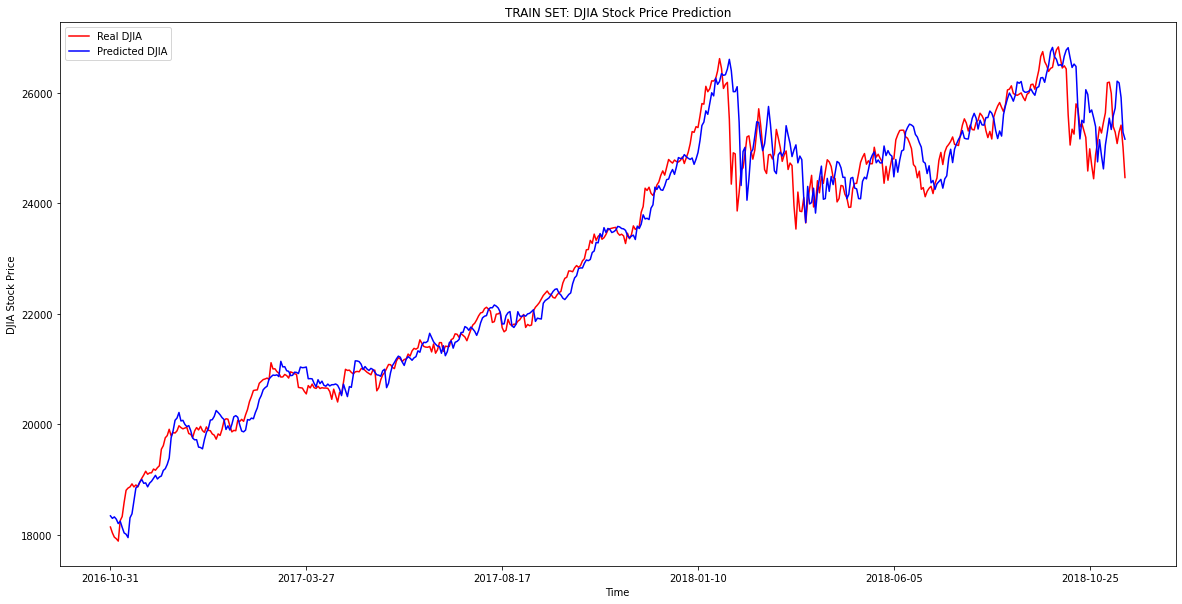

RMSE: 385.70519717961054


In [82]:
# Visualising the results
date = train_df[seq_length+step_predict:train_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, train_price, color = 'red', label = 'Real DJIA')
plt.plot(date, train_predicted, color = 'blue', label = 'Predicted DJIA')
plt.xticks(np.arange(0,len(train_predicted),100))
plt.title('TRAIN SET: DJIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DJIA Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(train_price, train_predicted, squared=False)}')

### Val set

In [83]:
val_price = val_df[seq_length+step_predict:val_df.shape[0]].Close
val_predicted = lstm_model.predict(X_val)
# val_predicted = sc.inverse_transform(val_predicted)
inv = val_df[seq_length:val_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
val_predicted = inv * np.exp(1)**val_predicted
len(val_price), len(val_predicted)

(103, 103)

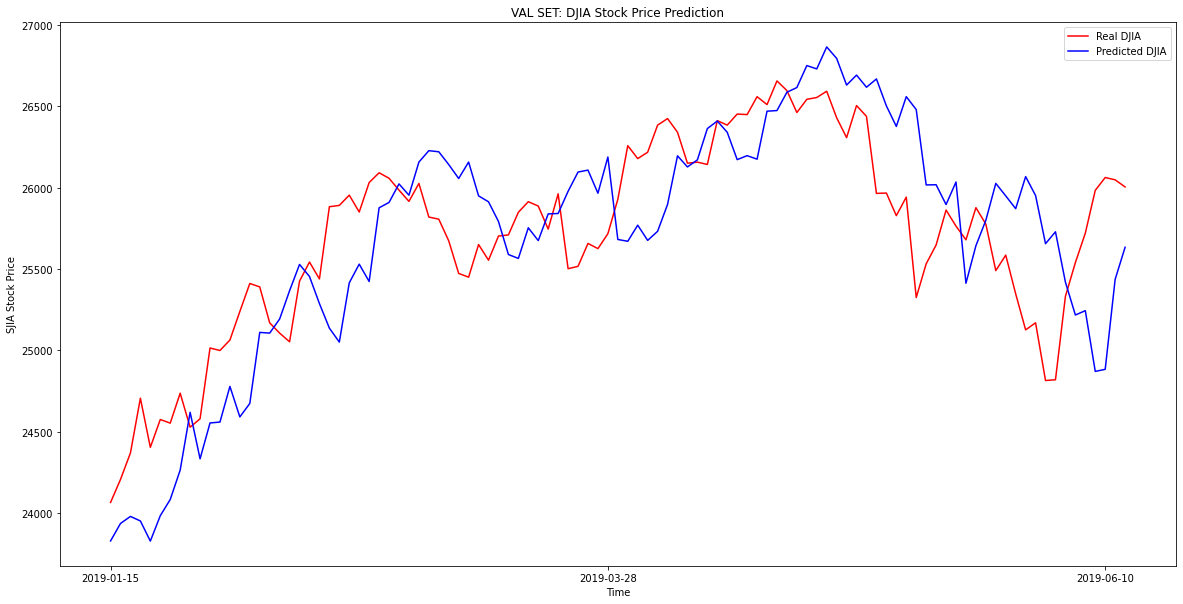

RMSE: 459.82607571659145


In [84]:
# Visualising the results
date = val_df[seq_length+step_predict:val_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, val_price, color = 'red', label = 'Real DJIA')
plt.plot(date, val_predicted, color = 'blue', label = 'Predicted DJIA')
plt.xticks(np.arange(0,len(val_predicted),50))
plt.title('VAL SET: DJIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SJIA Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(val_price, val_predicted, squared=False)}')

### Test set

In [85]:
# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].close_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'close_log'] = x

# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].vol_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'vol_log'] = x

# sc = MinMaxScaler().fit(test_df[1: test_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# x = sc.transform(test_df[1: test_df.shape[0]-step_predict].target_log.values.reshape(-1, 1))
# test_df.loc[1: test_df.shape[0]-step_predict-1, 'target_log'] = x

In [86]:
X_test = []
y_test = []
for i in range(seq_length, test_df.shape[0]-step_predict):
    X_test.append(test_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_test.append(test_df.loc[i-1, 'target_log'])
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
X_test.shape, y_test.shape

((104, 29, 2), (104,))

In [87]:
test_price = test_df[seq_length+step_predict:test_df.shape[0]].Close
test_predicted = lstm_model.predict(X_test)
# test_predicted = sc.inverse_transform(test_predicted)
inv = test_df[seq_length:test_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
test_predicted = inv * np.exp(1)**test_predicted
len(test_price), len(test_predicted)

(104, 104)

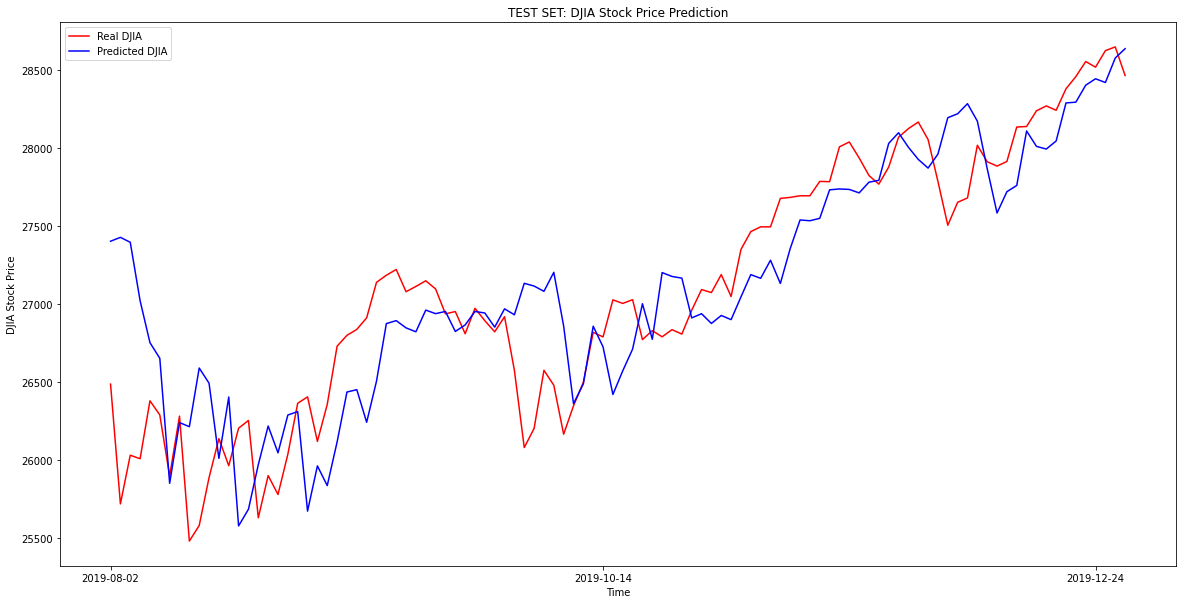

RMSE: 443.5807313796835


In [88]:
# Visualising the results
date = test_df[seq_length+step_predict:test_df.shape[0]].Date.values
plt.figure(figsize=(20,10))
plt.plot(date, test_price, color = 'red', label = 'Real DJIA')
plt.plot(date, test_predicted, color = 'blue', label = 'Predicted DJIA')
plt.xticks(np.arange(0,len(test_predicted),50))
plt.title('TEST SET: DJIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DJIA Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(test_price, test_predicted, squared=False)}')